In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Устанавливаем стиль для графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 10)

In [ ]:
tweet_df = pd.read_parquet('all_tweets_annotated.parquet')
candle_df = pd.read_csv('solana_EXQfMJKTnhHRv3xCzPttk9sZp6MKMdipeDnjKbGJq4fy.csv')

In [120]:
tweet_df['timestamp'] = pd.to_datetime(tweet_df['timestamp'], utc=True)
candle_df['timestamp'] = pd.to_datetime(candle_df['timestamp'], utc=True)

In [121]:
tweet_df_timed = tweet_df[
    (tweet_df['timestamp'] >= candle_df['timestamp'].min()) &
    (tweet_df['relevance_score_t'] > 0.9)
].copy()

In [122]:
tweet_df_timed['impact_score'] = (
    tweet_df_timed['reposts'] * 5 + 
    tweet_df_timed['likes'] * 2 + 
    tweet_df_timed['views'] * 0.1
)

tweet_df_timed['weighted_hype_index'] = (
    (tweet_df_timed['promo_score_x'] + tweet_df_timed['emotion_score_z'].abs()) * 
    tweet_df_timed['impact_score']
)

tweet_df_timed.set_index('timestamp', inplace=True)
tweet_agg_df = tweet_df_timed[['weighted_hype_index']].resample('1T').sum()

/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_75072/3232923379.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  tweet_agg_df = tweet_df_timed[['weighted_hype_index']].resample('1T').sum()


In [123]:
candle_df['price_change_pct'] = candle_df['close'].pct_change() * 100
candle_df.set_index('timestamp', inplace=True)

In [135]:
# Объединяем данные по свечам и агрегированные данные по твитам
combined_df = candle_df.merge(tweet_agg_df, left_index=True, right_index=True, how='left')

# Заполняем NaN нулями (если в какую-то минуту не было твитов, хайп равен 0)
combined_df['weighted_hype_index'].fillna(0, inplace=True)

/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_75072/112576728.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['weighted_hype_index'].fillna(0, inplace=True)


In [137]:
df_processed = combined_df.copy()
quantile_99 = df_processed['weighted_hype_index'].quantile(0.99)
print(f"Определен порог для выбросов (99-й перцентиль): {quantile_99:.2f}")
print("Все значения 'Hype Index' выше этого порога будут ограничены им.")
df_processed['hype_clipped'] = df_processed['weighted_hype_index'].clip(upper=quantile_99)

min_val = df_processed['hype_clipped'].min()
max_val = df_processed['hype_clipped'].max()

if max_val > min_val:
    df_processed['hype_normalized_pct'] = \
        (df_processed['hype_clipped'] - min_val) / (max_val - min_val) * 100
else:
    df_processed['hype_normalized_pct'] = 0

print(f"Новый диапазон 'Hype Index': от {df_processed['hype_normalized_pct'].min():.2f}% до {df_processed['hype_normalized_pct'].max():.2f}%")

Определен порог для выбросов (99-й перцентиль): 841.55
Все значения 'Hype Index' выше этого порога будут ограничены им.
Новый диапазон 'Hype Index': от 0.00% до 100.00%


In [140]:
WINDOW = '30T'
df_processed['hype_momentum'] = df_processed['hype_normalized_pct'].rolling(window=WINDOW).mean()

# --- Метрика 2: Ускорение хайпа (% изменения импульса) ---
# Мы используем .pct_change(periods=5), чтобы измерять ускорение каждые 5 минут
df_processed['hype_acceleration'] = df_processed['hype_momentum'].pct_change(periods=5) * 100
# Заменяем бесконечные значения (при делении на 0) на 0
df_processed.replace([np.inf, -np.inf], 0, inplace=True)

# --- Метрика 3: Скорость авторов (уникальные авторы) ---
# Для этого нам нужно вернуться к исходному tweet_df_timed, до агрегации
# Группируем по минутам и считаем количество уникальных авторов
author_counts = tweet_df_timed.resample('1T').agg({'author_username': 'nunique'})
author_counts.rename(columns={'author_username': 'unique_authors'}, inplace=True)

# Объединяем с нашим основным датафреймом
df_processed = df_processed.merge(author_counts, left_index=True, right_index=True, how='left')
df_processed['unique_authors'].fillna(0, inplace=True)

# Создаем скользящую сумму уникальных авторов, чтобы видеть общую вовлеченность
df_processed['author_velocity'] = df_processed['unique_authors'].rolling(window=WINDOW).sum()


print("Созданы новые метрики: 'hype_momentum', 'hype_acceleration', 'author_velocity'")

Созданы новые метрики: 'hype_momentum', 'hype_acceleration', 'author_velocity'


/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_75072/2926979893.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_processed['hype_momentum'] = df_processed['hype_normalized_pct'].rolling(window=WINDOW).mean()
/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_75072/2926979893.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  author_counts = tweet_df_timed.resample('1T').agg({'author_username': 'nunique'})
/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_75072/2926979893.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

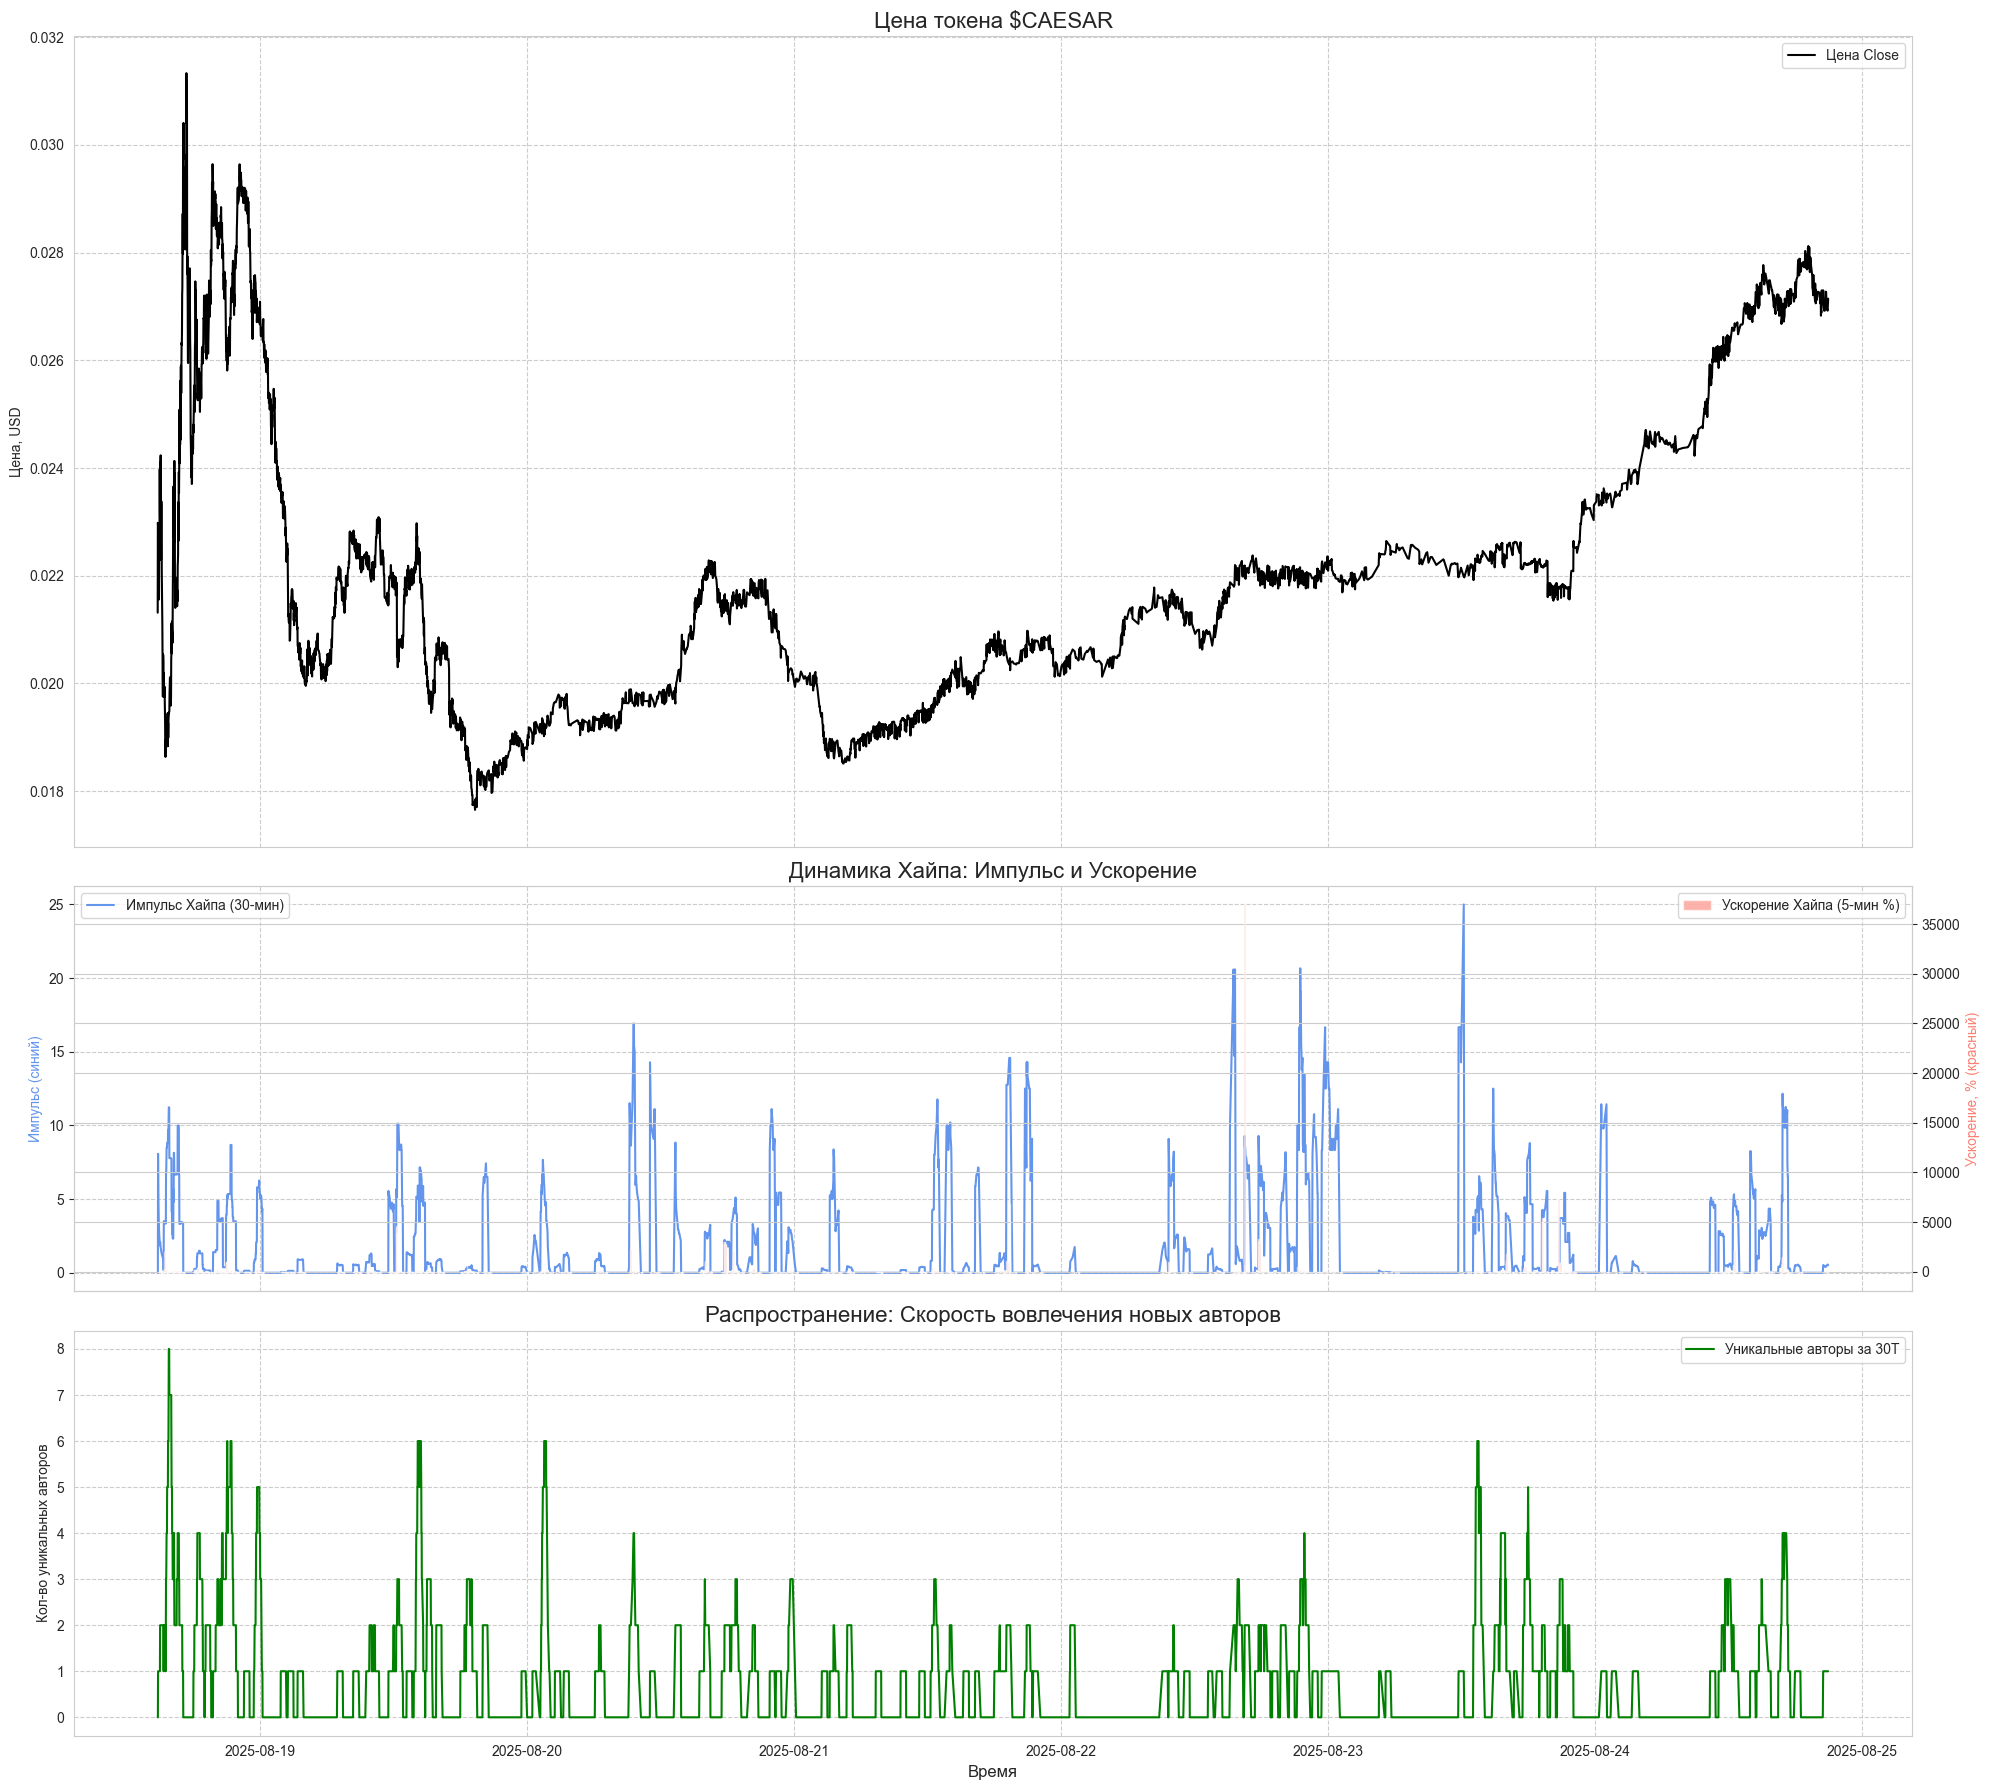

In [141]:
# --- ШАГ 2: Визуализация новых метрик ---

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, 
                                    sharex=True, 
                                    figsize=(20, 18), 
                                    gridspec_kw={'height_ratios': [2, 1, 1]})

# График 1: Цена (для контекста)
ax1.plot(df_processed.index, df_processed['close'], color='black', label='Цена Close')
ax1.set_title('Цена токена $CAESAR', fontsize=16)
ax1.set_ylabel('Цена, USD')
ax1.legend()
ax1.grid(True, linestyle='--')

# График 2: Импульс (Momentum) и Ускорение (Acceleration) Хайпа
# Используем две оси Y для разных масштабов
ax2_twin = ax2.twinx()
ax2.plot(df_processed.index, df_processed['hype_momentum'], color='cornflowerblue', label='Импульс Хайпа (30-мин)')
ax2_twin.bar(df_processed.index, df_processed['hype_acceleration'], width=0.002, color='salmon', alpha=0.6, label='Ускорение Хайпа (5-мин %)')
ax2.set_title('Динамика Хайпа: Импульс и Ускорение', fontsize=16)
ax2.set_ylabel('Импульс (синий)', color='cornflowerblue')
ax2_twin.set_ylabel('Ускорение, % (красный)', color='salmon')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')
ax2.grid(True, linestyle='--')

# График 3: Скорость Авторов (Author Velocity)
ax3.plot(df_processed.index, df_processed['author_velocity'], color='green', label=f'Уникальные авторы за {WINDOW}')
ax3.set_title('Распространение: Скорость вовлечения новых авторов', fontsize=16)
ax3.set_ylabel('Кол-во уникальных авторов')
ax3.set_xlabel('Время', fontsize=12)
ax3.legend()
ax3.grid(True, linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import spearmanr, mannwhitneyu
import pandas as pd
import numpy as np

# Убедимся, что df_processed существует и содержит нужные колонки
# df_processed = combined_df.copy() # ... и далее вся обработка из предыдущего шага
    
# --- 1. Практический бэктест (адаптированная версия) ---
# Эта функция осталась для оценки практической применимости стратегии

def run_practical_backtest(df, hype_threshold_pct_X, price_change_Y, time_window_Z):
    """
    Проверяет гипотезу: "Сигнал нормализованного хайпа > X% ведет к росту цены на > Y% в течение Z минут".
    """
    # Используем новую колонку 'hype_normalized_pct'
    signal_indices = df[df['hype_normalized_pct'] > hype_threshold_pct_X].index
    
    if len(signal_indices) == 0:
        return 0, 0, 0.0
        
    success_count = 0
    processed_signals = []

    for signal_time in signal_indices:
        is_duplicate = any((signal_time - proc_time).total_seconds() / 60 < time_window_Z for proc_time in processed_signals)
        if is_duplicate:
            continue

        window_end = signal_time + pd.Timedelta(minutes=time_window_Z)
        window_df = df.loc[signal_time:window_end]
        
        if not window_df.empty:
            initial_price = window_df['open'].iloc[0]
            max_price_in_window = window_df['high'].max()
            max_change = ((max_price_in_window - initial_price) / initial_price) * 100
            
            if max_change >= price_change_Y:
                success_count += 1
        
        processed_signals.append(signal_time)

    total_signals = len(processed_signals)
    success_rate = (success_count / total_signals) * 100 if total_signals > 0 else 0
    return success_count, total_signals, success_rate

# --- 2. Статистический тест 1: Корреляция Спирмена ---

print("--- Статистический тест 1: Корреляция Спирмена ---")
# Мы хотим проверить корреляцию между текущим хайпом и будущим изменением цены.
# Создадим колонку с максимальным ростом цены в следующие 30 минут.
LOOKAHEAD_MINUTES = 30
df_processed['future_max_return'] = (
    df_processed['high'].rolling(window=LOOKAHEAD_MINUTES).max().shift(-LOOKAHEAD_MINUTES) 
    - df_processed['open']
) / df_processed['open'] * 100

# Удаляем строки с NaN, которые образовались в конце датасета из-за сдвига
corr_df = df_processed[['hype_normalized_pct', 'future_max_return']].dropna()

# Рассчитываем корреляцию и p-value
correlation, p_value_corr = spearmanr(corr_df['hype_normalized_pct'], corr_df['future_max_return'])

print(f"Корреляция Спирмена между хайпом и макс. ростом за {LOOKAHEAD_MINUTES} мин: {correlation:.4f}")
print(f"P-value: {p_value_corr:.4f}")

if p_value_corr < 0.05:
    print("Результат СТАТИСТИЧЕСКИ ЗНАЧИМ: p-value < 0.05. Существует значимая связь между хайпом и будущим ростом цены.")
else:
    print("Результат НЕ является статистически значимым: p-value >= 0.05. Связь может быть случайной.")
print("-" * 50)


# --- 3. Статистический тест 2: Тест Манна-Уитни ---

def run_mann_whitney_test(df, hype_threshold_pct_X, time_window_Z):
    """
    Сравнивает распределения доходностей после "хайповых" и "спокойных" периодов.
    """
    # 1. Создаем колонку с будущей доходностью (максимальный рост в окне Z)
    df['future_return'] = (
        df['high'].rolling(window=time_window_Z).max().shift(-time_window_Z)
        - df['open']
    ) / df['open'] * 100

    # 2. Формируем две группы для сравнения
    df_clean = df[['hype_normalized_pct', 'future_return']].dropna()
    
    hype_returns = df_clean[df_clean['hype_normalized_pct'] > hype_threshold_pct_X]['future_return']
    baseline_returns = df_clean[df_clean['hype_normalized_pct'] <= hype_threshold_pct_X]['future_return']
    
    if len(hype_returns) < 20 or len(baseline_returns) < 20: # Проверка на достаточный размер выборки
        return None, None, None

    # 3. Проводим тест. alternative='greater' проверяет гипотезу, что доходности в hype_returns > baseline_returns
    statistic, p_value = mannwhitneyu(hype_returns, baseline_returns, alternative='greater')
    
    return statistic, p_value, (hype_returns.median(), baseline_returns.median())

# --- Запускаем эксперименты для обоих подходов ---

print("\n--- Запуск экспериментов ---")

# Пул гипотез. Пороги для хайпа теперь в процентах!
hype_thresholds_pct = [50, 70, 80, 90] # Уровни "хайпа" в %
price_targets_Y = [5, 10] # Целевой рост цены в %
time_windows_Z = [15, 30, 60] # Временное окно в минутах

for Z in time_windows_Z:
    print(f"\n===== АНАЛИЗ ДЛЯ ВРЕМЕННОГО ОКНА: {Z} минут =====\n")
    
    print("--- Результаты практического бэктеста ---")
    for X_pct in hype_thresholds_pct:
        for Y in price_targets_Y:
            successes, total_signals, success_rate = run_practical_backtest(df_processed, X_pct, Y, Z)
            if total_signals > 0:
                print(
                    f"Гипотеза: Хайп > {X_pct}% -> Рост > {Y}% | "
                    f"Результат: {successes} из {total_signals} ({success_rate:.2f}%)"
                )
    
    print("\n--- Результаты теста Манна-Уитни ---")
    for X_pct in hype_thresholds_pct:
        stat, p_val, medians = run_mann_whitney_test(df_processed, X_pct, Z)
        if p_val is not None:
            print(f"Порог хайпа > {X_pct}%: p-value = {p_val:.4f}. ", end="")
            if p_val < 0.05:
                print(f"ЗНАЧИМО! Медианный рост: {medians[0]:.2f}% (против {medians[1]:.2f}% в базе)")
            else:
                print("НЕ ЗНАЧИМО.")

--- Статистический тест 1: Корреляция Спирмена ---
Корреляция Спирмена между хайпом и макс. ростом за 30 мин: 0.0057
P-value: 0.7093
Результат НЕ является статистически значимым: p-value >= 0.05. Связь может быть случайной.
--------------------------------------------------

--- Запуск экспериментов ---

===== АНАЛИЗ ДЛЯ ВРЕМЕННОГО ОКНА: 15 минут =====

--- Результаты практического бэктеста ---
Гипотеза: Хайп > 50% -> Рост > 5% | Результат: 2 из 48 (4.17%)
Гипотеза: Хайп > 50% -> Рост > 10% | Результат: 1 из 48 (2.08%)
Гипотеза: Хайп > 70% -> Рост > 5% | Результат: 1 из 39 (2.56%)
Гипотеза: Хайп > 70% -> Рост > 10% | Результат: 1 из 39 (2.56%)
Гипотеза: Хайп > 80% -> Рост > 5% | Результат: 1 из 39 (2.56%)
Гипотеза: Хайп > 80% -> Рост > 10% | Результат: 1 из 39 (2.56%)
Гипотеза: Хайп > 90% -> Рост > 5% | Результат: 1 из 39 (2.56%)
Гипотеза: Хайп > 90% -> Рост > 10% | Результат: 1 из 39 (2.56%)

--- Результаты теста Манна-Уитни ---
Порог хайпа > 50%: p-value = 0.0316. ЗНАЧИМО! Медианный 

In [144]:
# --- ШАГ 1: Проверка обратной причинности ---
print("--- Проверка: Влияет ли ЦЕНА на будущий ХАЙП? ---")

# Сдвигаем хайп НАЗАД во времени. 
# Теперь в одной строке будет цена в момент T и хайп в момент T+5 минут.
df_processed['hype_shifted_forward_5T'] = df_processed['hype_normalized_pct'].shift(-5)
df_processed['hype_shifted_forward_15T'] = df_processed['hype_normalized_pct'].shift(-15)

# Считаем корреляцию между текущим изменением цены и хайпом, который будет через 5 и 15 минут
corr_5_min_lag = df_processed['price_change_pct'].corr(df_processed['hype_shifted_forward_5T'])
corr_15_min_lag = df_processed['price_change_pct'].corr(df_processed['hype_shifted_forward_15T'])

print(f"Корреляция между ростом цены СЕЙЧАС и хайпом через 5 минут: {corr_5_min_lag:.4f}")
print(f"Корреляция между ростом цены СЕЙЧАС и хайпом через 15 минут: {corr_15_min_lag:.4f}")

if corr_5_min_lag > 0.1 or corr_15_min_lag > 0.1:
    print("\nВЫВОД: Обнаружена ВЕРОЯТНАЯ ОБРАТНАЯ СВЯЗЬ. Рост цены, скорее всего, вызывает хайп, а не наоборот.")
else:
    print("\nВЫВОД: Явной обратной связи не обнаружено. Можно продолжать искать влияние твитов на цену.")

--- Проверка: Влияет ли ЦЕНА на будущий ХАЙП? ---
Корреляция между ростом цены СЕЙЧАС и хайпом через 5 минут: -0.0039
Корреляция между ростом цены СЕЙЧАС и хайпом через 15 минут: -0.0395

ВЫВОД: Явной обратной связи не обнаружено. Можно продолжать искать влияние твитов на цену.


In [145]:
# --- ШАГ 2: Проверка влияния на ВОЛАТИЛЬНОСТЬ ---
print("\n--- Проверка: Влияет ли ХАЙП на ВОЛАТИЛЬНОСТЬ? ---")

# Создаем метрику волатильности (абсолютное изменение цены)
df_processed['price_volatility'] = df_processed['price_change_pct'].abs()

# Создаем метрику будущей волатильности
df_processed['future_volatility_30T'] = df_processed['price_volatility'].rolling(30).mean().shift(-30)

# Проверяем на корреляцию
corr_volatility, p_val_volatility = spearmanr(
    df_processed[['hype_normalized_pct', 'future_volatility_30T']].dropna()
)

print(f"Корреляция Спирмена между хайпом и будущей волатильностью (30 мин): {corr_volatility:.4f}")
print(f"P-value: {p_val_volatility:.4f}")

if p_val_volatility < 0.05 and corr_volatility > 0:
    print("\nВЫВОД: СТАТИСТИЧЕСКИ ЗНАЧИМО! Хайп в Twitter связан с ростом волатильности цены в будущем.")
else:
    print("\nВЫВОД: Значимой связи между хайпом и будущей волатильностью не найдено.")


--- Проверка: Влияет ли ХАЙП на ВОЛАТИЛЬНОСТЬ? ---
Корреляция Спирмена между хайпом и будущей волатильностью (30 мин): 0.0102
P-value: 0.5084

ВЫВОД: Значимой связи между хайпом и будущей волатильностью не найдено.


In [146]:
# --- ШАГ 3: Сегментация сигнала ---
print("\n--- Проверка: Какой ТИП твитов влияет на цену? ---")

# Возвращаемся к неагрегированным данным
# Создаем индексы для разных типов твитов
tweet_df_timed['shill_index'] = (tweet_df_timed['promo_score_x'] * tweet_df_timed['impact_score']).clip(lower=0)
tweet_df_timed['analytical_index'] = (tweet_df_timed['depth_score_y'] * tweet_df_timed['impact_score']).clip(lower=0)
tweet_df_timed['emotional_index'] = (tweet_df_timed['emotion_score_z'].abs() * tweet_df_timed['impact_score']).clip(lower=0)

# Агрегируем каждый индекс отдельно
shill_agg = tweet_df_timed.resample('1T').agg({'shill_index': 'sum'})
analytical_agg = tweet_df_timed.resample('1T').agg({'analytical_index': 'sum'})
emotional_agg = tweet_df_timed.resample('1T').agg({'emotional_index': 'sum'})

# Добавляем в основной датафрейм
df_processed = df_processed.merge(shill_agg, left_index=True, right_index=True, how='left').fillna(0)
df_processed = df_processed.merge(analytical_agg, left_index=True, right_index=True, how='left').fillna(0)
df_processed = df_processed.merge(emotional_agg, left_index=True, right_index=True, how='left').fillna(0)

# Теперь проверяем корреляцию каждого индекса с будущим ростом
for signal_type in ['shill_index', 'analytical_index', 'emotional_index']:
    corr, p_val = spearmanr(df_processed[[signal_type, 'future_max_return']].dropna())
    print(f"Корреляция для '{signal_type}': {corr:.4f} (p-value: {p_val:.4f})")


--- Проверка: Какой ТИП твитов влияет на цену? ---
Корреляция для 'shill_index': 0.0061 (p-value: 0.6905)
Корреляция для 'analytical_index': 0.0128 (p-value: 0.4045)
Корреляция для 'emotional_index': 0.0065 (p-value: 0.6714)


/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_75072/2036139864.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  shill_agg = tweet_df_timed.resample('1T').agg({'shill_index': 'sum'})
/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_75072/2036139864.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  analytical_agg = tweet_df_timed.resample('1T').agg({'analytical_index': 'sum'})
/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_75072/2036139864.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  emotional_agg = tweet_df_timed.resample('1T').agg({'emotional_index': 'sum'})


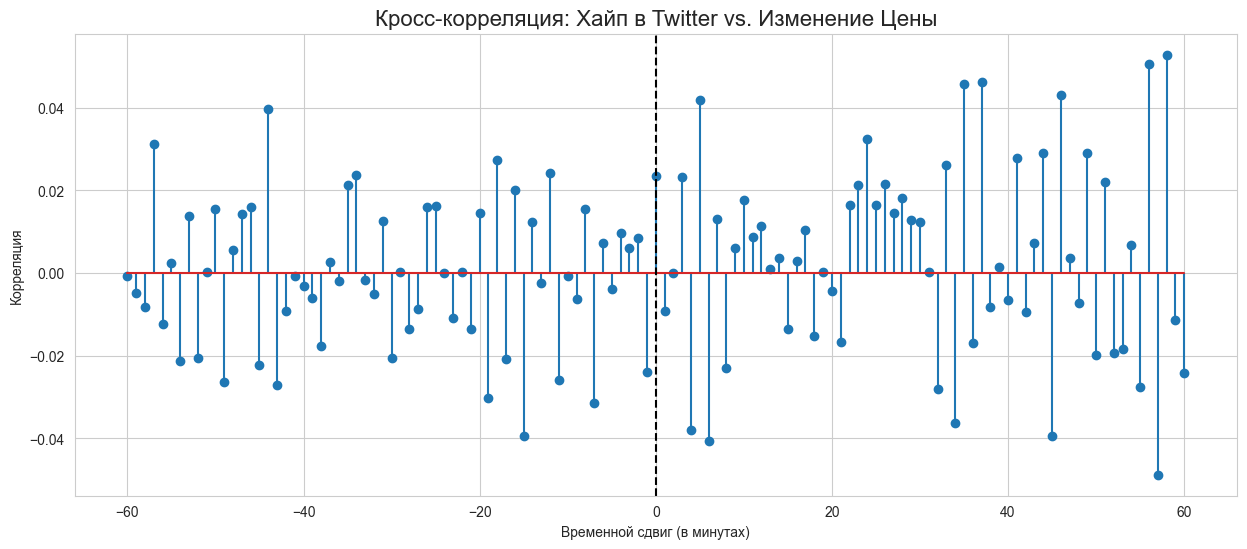

In [147]:
# --- ШАГ 4: Поиск оптимального лага с помощью кросс-корреляции ---
lags = range(-60, 61) # Проверяем сдвиги от -60 до +60 минут
correlations = [df_processed['price_change_pct'].corr(df_processed['hype_normalized_pct'].shift(lag)) for lag in lags]

plt.figure(figsize=(15, 6))
plt.stem(lags, correlations)
plt.title('Кросс-корреляция: Хайп в Twitter vs. Изменение Цены', fontsize=16)
plt.xlabel('Временной сдвиг (в минутах)')
plt.ylabel('Корреляция')
plt.grid(True)
plt.axvline(0, color='black', linestyle='--')
plt.show()